Import stuff
------------

In [1]:
import os
import sys

import numpy as np

import tensorflow as tf
from tensorflow import keras

# Change this with the directory where you cloned the imgdetect-utils repo
basedir = os.path.join(os.path.expanduser('~'), 'Downloads/uv_cleaner/human_detection')
sys.path.append(os.path.join(basedir))
sys.path.append(os.path.join(basedir, 'imgdetect-utils'))

from src.image_helpers import plot_images_grid, create_dataset_files
from src.train_helpers import load_data, plot_results, export_model

# The Tensorflow model and properties file will be stored here
tf_model_dir = os.path.join(basedir, 'models', 'tensorflow')
tf_model_file = os.path.join(tf_model_dir, 'human_detection.h5')
tf_properties_file = os.path.join(tf_model_dir, 'human_detection.json')

# Base directory that contains your training images and dataset files
dataset_base_dir = os.path.join(basedir, 'datasets')
dataset_dir = os.path.join(dataset_base_dir, 'data')

# Store your thermal camera images here
img_dir = os.path.join(dataset_base_dir, 'images')

# Size of the input images
input_size = (24, 32)

Create model directories
------------------------

In [2]:
os.makedirs(tf_model_dir, mode=0o775, exist_ok=True)

Create a dataset files from the available images
------------------------------------------------

In [3]:
dataset_files = create_dataset_files(img_dir, dataset_dir,
                                     split_size=500,
                                     num_threads=1,
                                     resize=input_size,
                                     color_convert='COLOR_BGR2GRAY')
dataset_files

Processing 2085 images to 5 dataset files. Format: /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset{:01}.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset0.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset1.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset2.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset3.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset4.npz


['/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset0.npz',
 '/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset1.npz',
 '/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset2.npz',
 '/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset3.npz',
 '/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset4.npz']

Get the training and test set randomly out of the dataset with a split of 70/30
-------------------------------------------------------------------------------

In [4]:
train_set, test_set, classes = load_data(*dataset_files, split_percentage=0.7)
print('Loaded {} training images and {} test images. Classes: {}'.format(
    train_set.shape[0], test_set.shape[0], classes))

Loaded 1459 training images and 626 test images. Classes: ['negative' 'positive']


/Users/hyungjaekim/opt/anaconda3/envs/uv_cleaner/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [5]:
train_images = np.asarray([item[0] for item in train_set])
train_labels = np.asarray([item[1] for item in train_set])
test_images = np.asarray([item[0] for item in test_set])
test_labels = np.asarray([item[1] for item in test_set])

Inspect the first 25 images in the training set
-----------------------------------------------


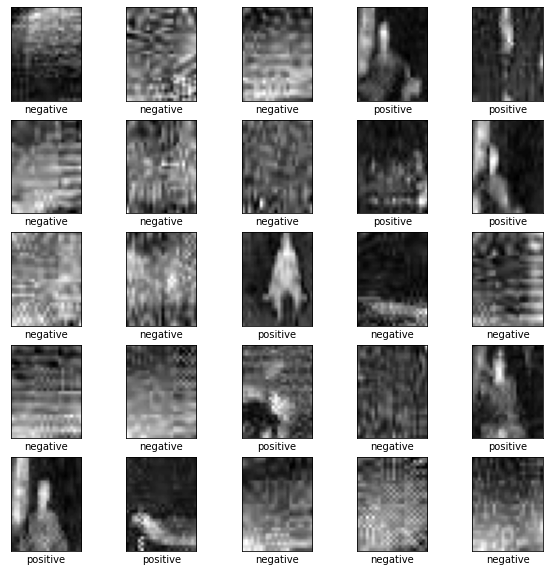

In [6]:
plot_images_grid(images=train_images, labels=train_labels, classes=classes, rows=5, cols=5)


Declare the model
-----------------

* Flatten input
* Layer 1: 60% the number of pixels per image
* Layer 2: 30% the number of pixels per image
* Layer 3: as many neurons as the output labels (in this case 2: negative, positive)

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images[0].shape),
    keras.layers.Dense(int(0.6 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(int(0.3 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(len(classes), activation=tf.nn.softmax)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Compile the model
-----------------

- *Loss function*:This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
- *Optimizer*: This is how the model is updated based on the data it sees and its loss function.
- *Metrics*: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train the model
---------------

In [ ]:
model.fit(train_images, train_labels, epochs=1000)

Train on 1459 samples
Epoch 1/1000
  32/1459 [..............................] - ETA: 3s - loss: 0.8007 - acc: 0.5312

2021-08-08 18:53:49.946465: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-08 18:53:49.958956: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe1aa03fd70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-08 18:53:49.958972: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


1459/1459 [==============================] - 0s 137us/sample - loss: 0.7631 - acc: 0.5805
Epoch 2/1000
1459/1459 [==============================] - 0s 76us/sample - loss: 0.6012 - acc: 0.6552
Epoch 3/1000
1459/1459 [==============================] - 0s 73us/sample - loss: 0.5680 - acc: 0.6998
Epoch 4/1000
1459/1459 [==============================] - 0s 73us/sample - loss: 0.5012 - acc: 0.7258
Epoch 5/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.6268 - acc: 0.6518
Epoch 6/1000
1459/1459 [==============================] - 0s 74us/sample - loss: 0.4635 - acc: 0.7683
Epoch 7/1000
1459/1459 [==============================] - 0s 104us/sample - loss: 0.4382 - acc: 0.7615
Epoch 8/1000
1459/1459 [==============================] - 0s 80us/sample - loss: 0.3984 - acc: 0.8156
Epoch 9/1000
1459/1459 [==============================] - 0s 84us/sample - loss: 0.4211 - acc: 0.7916
Epoch 10/1000
1459/1459 [==============================] - 0s 79us/sample - loss: 0.4489 - ac

1459/1459 [==============================] - 0s 83us/sample - loss: 0.3521 - acc: 0.8465
Epoch 81/1000
1459/1459 [==============================] - 0s 86us/sample - loss: 0.2663 - acc: 0.9006
Epoch 82/1000
1459/1459 [==============================] - 0s 84us/sample - loss: 0.3556 - acc: 0.8465
Epoch 83/1000
1459/1459 [==============================] - 0s 76us/sample - loss: 0.3289 - acc: 0.8472
Epoch 84/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.2920 - acc: 0.8828
Epoch 85/1000
1459/1459 [==============================] - 0s 72us/sample - loss: 0.3002 - acc: 0.8663
Epoch 86/1000
1459/1459 [==============================] - 0s 85us/sample - loss: 0.2977 - acc: 0.8753
Epoch 87/1000
1459/1459 [==============================] - 0s 134us/sample - loss: 0.3468 - acc: 0.8403
Epoch 88/1000
1459/1459 [==============================] - 0s 98us/sample - loss: 0.2839 - acc: 0.8821
Epoch 89/1000
1459/1459 [==============================] - 0s 108us/sample - loss: 0.2

1459/1459 [==============================] - 0s 78us/sample - loss: 0.2258 - acc: 0.9130
Epoch 160/1000
1459/1459 [==============================] - 0s 73us/sample - loss: 0.2125 - acc: 0.9184
Epoch 161/1000
1459/1459 [==============================] - 0s 72us/sample - loss: 0.2328 - acc: 0.9136
Epoch 162/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.2217 - acc: 0.9157
Epoch 163/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.2218 - acc: 0.9157
Epoch 164/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.2019 - acc: 0.9232
Epoch 165/1000
1459/1459 [==============================] - 0s 72us/sample - loss: 0.2577 - acc: 0.8972
Epoch 166/1000
1459/1459 [==============================] - 0s 70us/sample - loss: 0.1982 - acc: 0.9308
Epoch 167/1000
1459/1459 [==============================] - 0s 70us/sample - loss: 0.2843 - acc: 0.8773
Epoch 168/1000
1459/1459 [==============================] - 0s 78us/sample - lo

1459/1459 [==============================] - 0s 80us/sample - loss: 0.1613 - acc: 0.9397
Epoch 238/1000
1459/1459 [==============================] - 0s 80us/sample - loss: 0.2311 - acc: 0.9109
Epoch 239/1000
1459/1459 [==============================] - 0s 77us/sample - loss: 0.2565 - acc: 0.8910
Epoch 240/1000
1459/1459 [==============================] - 0s 79us/sample - loss: 0.1750 - acc: 0.9404
Epoch 241/1000
1459/1459 [==============================] - 0s 78us/sample - loss: 0.1821 - acc: 0.9246
Epoch 242/1000
1459/1459 [==============================] - 0s 80us/sample - loss: 0.1921 - acc: 0.9246
Epoch 243/1000
1459/1459 [==============================] - 0s 78us/sample - loss: 0.1963 - acc: 0.9184
Epoch 244/1000
1459/1459 [==============================] - 0s 80us/sample - loss: 0.1990 - acc: 0.9301
Epoch 245/1000
1459/1459 [==============================] - 0s 80us/sample - loss: 0.1527 - acc: 0.9493
Epoch 246/1000
1459/1459 [==============================] - 0s 81us/sample - lo

1459/1459 [==============================] - 0s 75us/sample - loss: 0.1281 - acc: 0.9493
Epoch 316/1000
1459/1459 [==============================] - 0s 72us/sample - loss: 0.1442 - acc: 0.9431
Epoch 317/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.1898 - acc: 0.9267
Epoch 318/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.1098 - acc: 0.9596
Epoch 319/1000
1459/1459 [==============================] - 0s 72us/sample - loss: 0.1101 - acc: 0.9609
Epoch 320/1000
1459/1459 [==============================] - 0s 72us/sample - loss: 0.1962 - acc: 0.9239
Epoch 321/1000
1459/1459 [==============================] - 0s 70us/sample - loss: 0.1526 - acc: 0.9376
Epoch 322/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.2408 - acc: 0.9006
Epoch 323/1000
1459/1459 [==============================] - 0s 71us/sample - loss: 0.1548 - acc: 0.9424
Epoch 324/1000
1459/1459 [==============================] - 0s 71us/sample - lo

1459/1459 [==============================] - 0s 93us/sample - loss: 0.1155 - acc: 0.9534
Epoch 394/1000
1459/1459 [==============================] - 0s 94us/sample - loss: 0.1144 - acc: 0.9616
Epoch 395/1000
1459/1459 [==============================] - 0s 86us/sample - loss: 0.1407 - acc: 0.9431
Epoch 396/1000
1459/1459 [==============================] - 0s 88us/sample - loss: 0.1981 - acc: 0.9191
Epoch 397/1000
1459/1459 [==============================] - 0s 80us/sample - loss: 0.0843 - acc: 0.9726
Epoch 398/1000
 672/1459 [============>.................] - ETA: 0s - loss: 0.2032 - acc: 0.906 - ETA: 0s - loss: 0.1171 - acc: 0.9554

Evaluate accuracy against the test set
--------------------------------------

In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

626/626 [==============================] - 0s 114us/sample - loss: 0.3451 - acc: 0.9681
Test accuracy: 0.96805114


Make predictions on the test set
--------------------------------

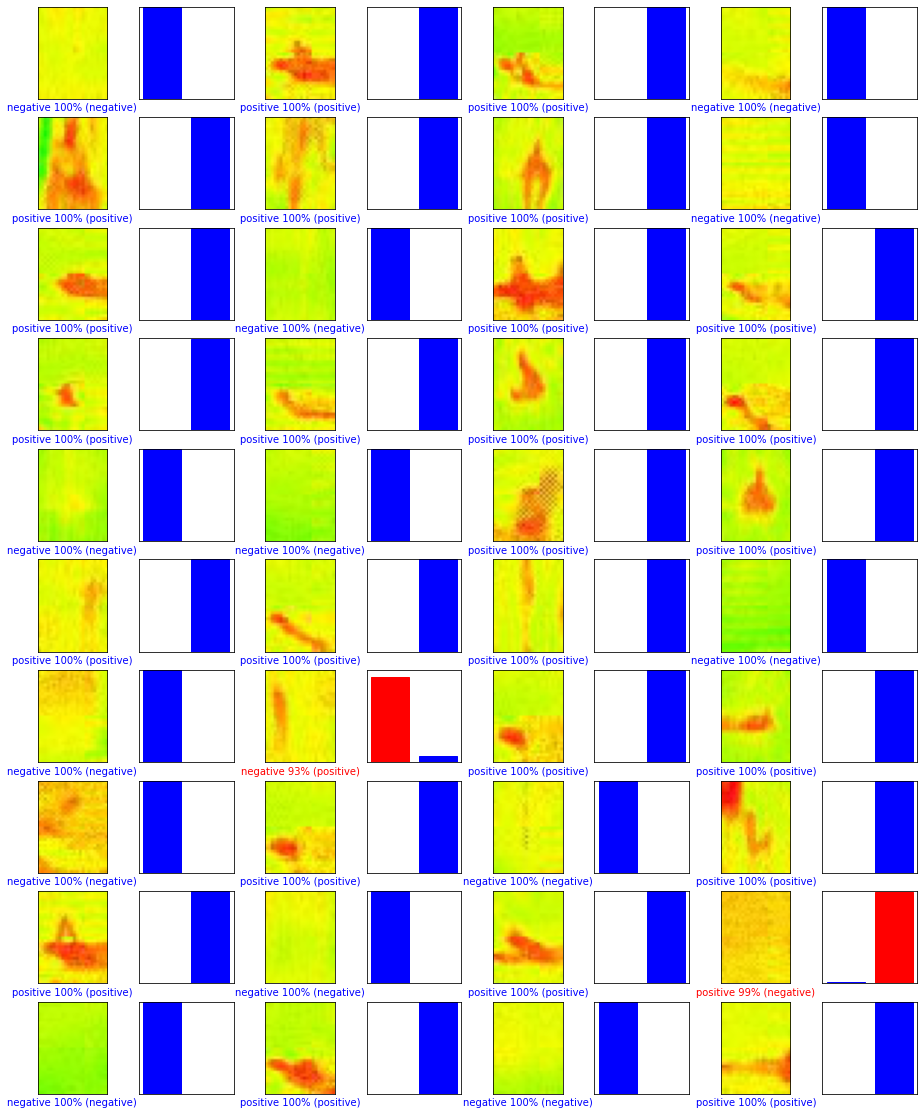

In [11]:
predictions = model.predict(test_images)
plot_results(images=test_images, labels=test_labels, classes=classes, predictions=predictions, rows=10, cols=4)

Export as a Tensorflow model
----------------------------

In [12]:
export_model(model, tf_model_file,
             properties_file=tf_properties_file,
             classes=classes,
             input_size=input_size)



Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 23 variables.
INFO:tensorflow:Converted 23 variables to const ops.

